## Parameters
Golovin Kernel, A = 1e-4 cm3/sec

**Collocation**
```
casename = "examples/geometric8_IC1_"

    # Numerical parameters
    FT = Float64
    tspan = (0.0, 4*3600.0)

    # basis setup 
    Nb = 8
    rmax  = 200.0
    rmin  = 2.0
    vmin = 4/3*pi*rmin^3
    vmax = 4/3*pi*rmax^3

    r_cutoff = 25
    v_cutoff = 4/3*pi*r_cutoff^3

    # Physical parameters: Kernel
    a = 0.0
    b = 0.0
    c = pi * 1e-12
    r = v->(3/4/pi*v)^(1/3)
    area = v->4*pi*r(v)^2
    kernel_func = x -> a + b*(x[1]+x[2]) + c*(r(x[1])+r(x[2]))^2*abs(area(x[1])-area(x[2]))
    tracked_moments = [1.0]
    inject_rate = 0
    N     = 100           # initial droplet density: number per cm^3
    θ_v   = 1000          # volume scale factor: µm^3
    θ_r   = 3             # radius scale factor: µm
    k     = 3             # shape factor for particle size distribution 
    ρ_w   = 1.0e-12       # density of droplets: 1 g/µm^3
```

**Bott**
```
Tmax, nbin, dt, scal, emin, rhow, B, k1, theta, N0 
[7200, 32, 1.0, 1, 7.091336e-10, 1e-09, 1.5e-12, 3, 1000, 100]
gmin = 1e-10
```

## PySDM

In [1]:
import sys, os
os.environ["NUMBA_DISABLE_JIT"] = "1"

import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Collision
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity, UniformRandom

from PySDM.products.size_spectral import ParticleVolumeVersusRadiusLogarithmSpectrum, ParticleSizeSpectrumPerVolume
import PySDM.products.size_spectral.arbitrary_moment as am
from PySDM.products.housekeeping.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Gamma
from PySDM.dynamics.collisions.collision_kernels import SimpleGeometric
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.dynamics.collisions.breakup_efficiencies import ConstEb
from PySDM.dynamics.collisions.breakup_fragmentations import AlwaysN
from PySDM.physics.constants import si
from PySDM.physics.constants_defaults import rho_w, rho_STP
from PySDM import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'default'

from scipy.stats import gamma

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (idx, array[idx])

In [3]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**15
        self.n_part = 100 / si.cm**3
        self.k = 3
        self.theta = 1000 * si.um**3
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 60 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 4*3600.0]
        self.kernel = SimpleGeometric(C=np.pi * 1e-12 * si.cm**3 / si.um**4 / si.s)
        self.coal_eff = ConstEc(Ec=1.0)
        self.fragmentation = AlwaysN(n=1)
        self.break_eff = ConstEb(0.0) # no "bouncing"
        self.spectrum = Gamma(norm_factor=self.norm_factor, theta=self.theta, k=self.k)
        self.radius_bins_edges = np.logspace(np.log10(1 * si.um), np.log10(1000 * si.um), num=128, endpoint=True)
        self.volume_bins_edges = self.radius_bins_edges**3 * 4 * np.pi / 3
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

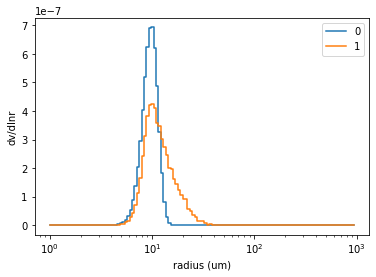

In [4]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
# env['rhod'] = 1
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
products = [dvdlnr, nv]
core = builder.build(attributes, products)
sdm_y = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_y1 = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
i = 0
v_cutoff = 1e3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]
dr = settings.radius_bins_edges[1:] - settings.radius_bins_edges[:-1]
for step in settings.output_steps:
    core.run(step - core.n_steps)
    sdm_y[:,i] = core.products['N(v)'].get() * si.cm**3 * dr
    sdm_y1[:,i] = core.products['dv/dlnr'].get()[0]
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.um, 
            y=sdm_y1[:,i],
            where='post', label="t = {step*settings.dt}s")
    i += 1
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dv/dlnr")
pyplot.legend([0, 1, 2])
#pyplot.xlim([1e1, 1e6])

In [5]:
dlnr = np.mean(np.log(settings.radius_bins_edges[1:]) - np.log(settings.radius_bins_edges[:-1]))

In [6]:
settings = Settings()
settings.n_sd = 2**13
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd) #UniformRandom(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)

M0 = am.make_arbitrary_moment_product(rank=0, attr='volume', attr_unit='dimensionless')(name='M0')
M1 = am.make_arbitrary_moment_product(rank=1, attr='volume', attr_unit='m^3')(name='M1')
M2 = am.make_arbitrary_moment_product(rank=2, attr='volume', attr_unit='m^6')(name='M2')
Nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
products = [M0, M1, M2, Nv, dvdlnr]
core = builder.build(attributes, products)
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
dx_sdm = np.diff(np.append([0.0], sdm_x))

r_cutoff = 25
v_cutoff = 4/3*np.pi*r_cutoff**3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]

mom0 = np.zeros(int(settings._steps[-1]/settings.dt))
mom1 = np.zeros(int(settings._steps[-1]/settings.dt))
mom2 = np.zeros(int(settings._steps[-1]/settings.dt))
sdm_precip = np.zeros(int(settings._steps[-1]/settings.dt))
i = 0
for step in range(int(settings._steps[-1]/settings.dt)):
    core.run(step - core.n_steps)
    mom0[i] = M0.get()
    mom1[i] = M1.get() 
    mom2[i] = M2.get()
    dvdlnr_instant = core.products['dv/dlnr'].get()[0] * si.cm**3 / si.um**3
    mv_instant = dvdlnr_instant*dlnr

    sdm_precip[i] = np.sum(mv_instant[bin_cutoff:])
    i += 1
times_sdm = range(0,int(settings._steps[-1]),int(settings.dt))


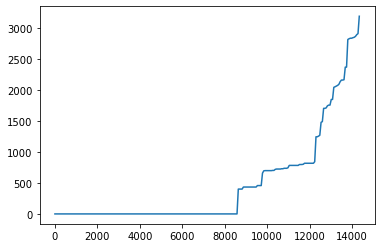

In [7]:
pyplot.plot(times_sdm, sdm_precip)

## Bin

In [8]:
# geometric_IC1
# Tmax, nbin, dt, scal, emin, rhow, A, k1, theta, N0 
# [14400.0, 32, 1.0, 1, 7.091336e-10, 1e-09, 0.0001, 3, 1000, 100]
# tolerance = 1e-8

v_grid = [1.06370040e+00, 2.12740080e+00, 4.25480160e+00, 8.50960320e+00,
 1.70192064e+01, 3.40384128e+01, 6.80768256e+01, 1.36153651e+02,
 2.72307302e+02, 5.44614605e+02, 1.08922921e+03, 2.17845842e+03,
 4.35691684e+03, 8.71383368e+03, 1.74276674e+04, 3.48553347e+04,
 6.97106694e+04, 1.39421339e+05, 2.78842678e+05, 5.57685355e+05,
 1.11537071e+06, 2.23074142e+06, 4.46148284e+06, 8.92296569e+06,
 1.78459314e+07, 3.56918627e+07, 7.13837255e+07, 1.42767451e+08,
 2.85534902e+08, 5.71069804e+08, 1.14213961e+09, 2.28427922e+09]
r_grid = [6.33252487e-01, 7.97848139e-01, 1.00522566e+00, 1.26650497e+00,
 1.59569628e+00, 2.01045133e+00, 2.53300995e+00, 3.19139256e+00,
 4.02090266e+00, 5.06601990e+00, 6.38278511e+00, 8.04180532e+00,
 1.01320398e+01, 1.27655702e+01, 1.60836106e+01, 2.02640796e+01,
 2.55311404e+01, 3.21672213e+01, 4.05281592e+01, 5.10622809e+01,
 6.43344425e+01, 8.10563184e+01, 1.02124562e+02, 1.28668885e+02,
 1.62112637e+02, 2.04249124e+02, 2.57337770e+02, 3.24225274e+02,
 4.08498247e+02, 5.14675540e+02, 6.48450547e+02, 8.16996494e+02]

gr0 = [1.91825611e-007, 3.06594679e-006, 4.89508996e-005, 7.79889052e-004,
 1.23724906e-002, 1.94619238e-001, 3.00969894e+000, 4.49860279e+001,
 6.28155044e+002, 7.65464890e+003, 7.10431387e+004, 3.82468690e+005,
 6.92824760e+005, 1.42088340e+005, 3.73515426e+002, 1.61320203e-004,
 1.88074197e-018, 1.59768126e-047, 7.20596272e-107, 9.16169370e-227,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]
gr30 = [1.69316266e-07, 2.69758082e-06, 4.28817210e-05, 6.79515231e-04,
 1.07093870e-02, 1.67143550e-01, 2.56184109e+00, 3.79397248e+01,
 5.25853228e+02, 6.40428673e+03, 6.03156715e+04, 3.34656918e+05,
 6.41312794e+05, 2.19691004e+05, 3.17253883e+04, 2.36735801e+03,
 8.76726466e+01, 1.80067024e+00, 2.50709756e-02, 2.61009299e-04,
 3.58501325e-09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
gr120 = [1.11519254e-07, 1.75981507e-06, 2.76085837e-05, 4.30410777e-04,
 6.64911704e-03, 1.01310637e-01, 1.51018135e+00, 2.17049658e+01,
 2.92831414e+02, 3.52537184e+03, 3.40848305e+04, 2.03279568e+05,
 4.42582231e+05, 2.97069357e+05, 1.74020005e+05, 8.92954146e+04,
 3.71485724e+04, 1.19832963e+04, 3.03123478e+03, 6.40102721e+02,
 1.23241815e+02, 2.36191333e+01, 5.03867016e+00, 1.27226426e+00,
 1.40646337e-01, 4.89282922e-09, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
t_bott = [    0.,   120.,   240.,   360.,   480.,   600.,   720.,   840.,   960.,
  1080.,  1200.,  1320.,  1440.,  1560.,  1680.,  1800.,  1920.,  2040.,
  2160.,  2280.,  2400.,  2520.,  2640.,  2760.,  2880.,  3000.,  3120.,
  3240.,  3360.,  3480.,  3600.,  3720.,  3840.,  3960.,  4080.,  4200.,
  4320.,  4440.,  4560.,  4680.,  4800.,  4920.,  5040.,  5160.,  5280.,
  5400.,  5520.,  5640.,  5760.,  5880.,  6000.,  6120.,  6240.,  6360.,
  6480.,  6600.,  6720.,  6840.,  6960.,  7080.,  7200.,  7320.,  7440.,
  7560.,  7680.,  7800.,  7920.,  8040.,  8160.,  8280.,  8400.,  8520.,
  8640.,  8760.,  8880.,  9000.,  9120.,  9240.,  9360.,  9480.,  9600.,
  9720.,  9840.,  9960., 10080., 10200., 10320., 10440., 10560., 10680.,
 10800., 10920., 11040., 11160., 11280., 11400., 11520., 11640., 11760.,
 11880., 12000., 12120., 12240., 12360., 12480., 12600., 12720., 12840.,
 12960., 13080., 13200., 13320., 13440., 13560., 13680., 13800., 13920.,
 14040., 14160., 14280., 14400.]
M0_bott = [100.01643568,  99.74838731,  99.47967873,  99.21043055,  98.94070222,
  98.67052961,  98.39993671,  98.12894059,  97.85755393,  97.58578642,
  97.31364558,  97.04113737,  96.76826655,  96.49503689,  96.22145145,
  95.94751264,  95.67322238,  95.39858214,  95.12359305,  94.84825591,
  94.57257127,  94.29653941,  94.02016045,  93.74343427,  93.46636064,
  93.18893914,  92.91116924,  92.63305027,  92.35458147,  92.07576195,
  91.79659075,  91.51706681,  91.23718899,  90.95695607,  90.67636678,
  90.39541975,  90.11411357,  89.83244676,  89.55041779,  89.26802508,
  88.98526698,  88.7021418 ,  88.41864782,  88.13478325,  87.85054627,
  87.56593501,  87.28094756,  86.99558199,  86.7098363 ,  86.42370848,
  86.13719647,  85.85029818,  85.56301147,  85.2753342 ,  84.98726416,
  84.69879913,  84.40993684,  84.12067502,  83.83101134,  83.54094344,
  83.25046895,  82.95958546,  82.66829051,  82.37658164,  82.08445635,
  81.7919121 ,  81.49894634,  81.20555647,  80.91173988,  80.61749392,
  80.3228159 ,  80.02770313,  79.73215287,  79.43616234,  79.13972875,
  78.84284927,  78.54552105,  78.2477412 ,  77.94950679,  77.65081488,
  77.35166249,  77.05204659,  76.75196413,  76.45141204,  76.1503872 ,
  75.84888646,  75.54690663,  75.24444448,  74.94149677,  74.63806018,
  74.3341314 ,  74.02970704,  73.72478368,  73.41935787,  73.11342611,
  72.80698486,  72.50003053,  72.19255948,  71.88456804,  71.57605247,
  71.26700899,  70.95743376,  70.6473229 ,  70.33667246,  70.02547845,
  69.71373679,  69.40144337,  69.08859399,  68.7751844 ,  68.46121028,
  68.14666722,  67.83155076,  67.51585635,  67.19957934,  66.88271502,
  66.56525859,  66.24720515,  65.92854969,  65.60928712,  65.28941223,
  64.96891971]
M1_bott = [299700.54085184, 299700.54085184, 299700.54085183, 299700.54085183,
 299700.54085182, 299700.54085182, 299700.54085182, 299700.54085182,
 299700.54085182, 299700.54085182, 299700.54085182, 299700.54085181,
 299700.54085181, 299700.54085181, 299700.54085181, 299700.54085181,
 299700.5408518 , 299700.54085179, 299700.54085179, 299700.54085179,
 299700.54085178, 299700.54085178, 299700.54085177, 299700.54085177,
 299700.54085176, 299700.54085176, 299700.54085176, 299700.54085175,
 299700.54085174, 299700.54085174, 299700.54085173, 299700.54085172,
 299700.5408517 , 299700.54085168, 299700.54085168, 299700.54085168,
 299700.54085168, 299700.54085169, 299700.54085169, 299700.54085169,
 299700.54085168, 299700.54085168, 299700.54085168, 299700.54085167,
 299700.54085166, 299700.54085166, 299700.54085165, 299700.54085163,
 299700.54085162, 299700.5408516 , 299700.54085156, 299700.54085152,
 299700.54085148, 299700.54085147, 299700.54085147, 299700.54085147,
 299700.54085147, 299700.54085147, 299700.54085147, 299700.54085147,
 299700.54085147, 299700.54085147, 299700.54085147, 299700.54085146,
 299700.54085145, 299700.54085143, 299700.54085141, 299700.54085138,
 299700.54085134, 299700.54085129, 299700.54085123, 299700.54085115,
 299700.54085105, 299700.54085105, 299700.54085105, 299700.54085105,
 299700.54085106, 299700.54085106, 299700.54085106, 299700.54085105,
 299700.54085104, 299700.54085103, 299700.54085102, 299700.540851  ,
 299700.54085096, 299700.54085092, 299700.54085086, 299700.54085078,
 299700.54085068, 299700.54085054, 299700.54085037, 299700.54085015,
 299700.54085005, 299700.54085005, 299700.54085005, 299700.54085005,
 299700.54085004, 299700.54085003, 299700.54085002, 299700.54085   ,
 299700.54084997, 299700.54084993, 299700.54084987, 299700.54084979,
 299700.54084968, 299700.54084953, 299700.54084934, 299700.54084908,
 299700.54084874, 299700.54084831, 299700.54084813, 299700.54084812,
 299700.54084812, 299700.5408481 , 299700.54084808, 299700.54084803,
 299700.54084795, 299700.54084784, 299700.54084767, 299700.54084741,
 299700.54084706]
M2_bott = [1.19640534e+09, 1.20225907e+09, 1.20824583e+09, 1.21434884e+09,
 1.22056070e+09, 1.22687759e+09, 1.23329752e+09, 1.23981958e+09,
 1.24644355e+09, 1.25316969e+09, 1.25999863e+09, 1.26693126e+09,
 1.27396871e+09, 1.28111227e+09, 1.28836341e+09, 1.29572372e+09,
 1.30319492e+09, 1.31077885e+09, 1.31847745e+09, 1.32629276e+09,
 1.33422691e+09, 1.34228213e+09, 1.35046075e+09, 1.35876518e+09,
 1.36719792e+09, 1.37576155e+09, 1.38445877e+09, 1.39329233e+09,
 1.40226512e+09, 1.41138008e+09, 1.42064027e+09, 1.43004885e+09,
 1.43960906e+09, 1.44932426e+09, 1.45919791e+09, 1.46923357e+09,
 1.47943493e+09, 1.48980578e+09, 1.50035003e+09, 1.51107171e+09,
 1.52197498e+09, 1.53306414e+09, 1.54434360e+09, 1.55581793e+09,
 1.56749182e+09, 1.57937015e+09, 1.59145791e+09, 1.60376027e+09,
 1.61628257e+09, 1.62903032e+09, 1.64200918e+09, 1.65522505e+09,
 1.66868396e+09, 1.68239219e+09, 1.69635620e+09, 1.71058267e+09,
 1.72507851e+09, 1.73985085e+09, 1.75490707e+09, 1.77025481e+09,
 1.78590196e+09, 1.80185668e+09, 1.81812743e+09, 1.83472294e+09,
 1.85165229e+09, 1.86892484e+09, 1.88655031e+09, 1.90453877e+09,
 1.92290064e+09, 1.94164673e+09, 1.96078825e+09, 1.98033684e+09,
 2.00030456e+09, 2.02070393e+09, 2.04154795e+09, 2.06285012e+09,
 2.08462447e+09, 2.10688557e+09, 2.12964855e+09, 2.15292918e+09,
 2.17674383e+09, 2.20110954e+09, 2.22604406e+09, 2.25156585e+09,
 2.27769416e+09, 2.30444903e+09, 2.33185137e+09, 2.35992296e+09,
 2.38868654e+09, 2.41816584e+09, 2.44838564e+09, 2.47937179e+09,
 2.51115138e+09, 2.54375276e+09, 2.57720554e+09, 2.61154072e+09,
 2.64679077e+09, 2.68298969e+09, 2.72017313e+09, 2.75837851e+09,
 2.79764506e+09, 2.83801401e+09, 2.87952865e+09, 2.92223453e+09,
 2.96617952e+09, 3.01141405e+09, 3.05799121e+09, 3.10596696e+09,
 3.15540034e+09, 3.20635361e+09, 3.25889282e+09, 3.31308863e+09,
 3.36901525e+09, 3.42675130e+09, 3.48638018e+09, 3.54799048e+09,
 3.61167637e+09, 3.67753805e+09, 3.74568226e+09, 3.81622279e+09,
 3.88928111e+09]
mprecip_bin = [3.69142754e-48, 2.14899159e-09, 8.18580886e-08, 6.83024977e-07,
 3.17312262e-06, 1.06822386e-05, 2.92644708e-05, 6.94169994e-05,
 1.47987768e-04, 2.90538386e-04, 5.34179603e-04, 9.30933654e-04,
 1.55166600e-03, 2.49063185e-03, 3.87068384e-03, 5.84918794e-03,
 8.62469568e-03, 1.24444270e-02, 1.76125955e-02, 2.44996374e-02,
 3.35524142e-02, 4.53054016e-02, 6.03929388e-02, 7.95625821e-02,
 1.03689615e-01, 1.33792763e-01, 1.71051165e-01, 2.16822644e-01,
 2.72663339e-01, 3.40348727e-01, 4.21896099e-01, 5.19588517e-01,
 6.36000320e-01, 7.74024191e-01, 9.36899874e-01, 1.12824446e+00,
 1.35208446e+00, 1.61288960e+00, 1.91560826e+00, 2.26570485e+00,
 2.66919889e+00, 3.13270592e+00, 3.66348037e+00, 4.26946015e+00,
 4.95931324e+00, 5.74248609e+00, 6.62925398e+00, 7.63077319e+00,
 8.75913513e+00, 1.00274223e+01, 1.14497662e+01, 1.30414070e+01,
 1.48187550e+01, 1.67994540e+01, 1.90024466e+01, 2.14480404e+01,
 2.41579773e+01, 2.71555030e+01, 3.04654393e+01, 3.41142566e+01,
 3.81301492e+01, 4.25431112e+01, 4.73850140e+01, 5.26896844e+01,
 5.84929852e+01, 6.48328954e+01, 7.17495920e+01, 7.92855330e+01,
 8.74855403e+01, 9.63968840e+01, 1.06069367e+02, 1.16555409e+02,
 1.27910133e+02, 1.40191450e+02, 1.53460144e+02, 1.67779957e+02,
 1.83217675e+02, 1.99843210e+02, 2.17729688e+02, 2.36953528e+02,
 2.57594526e+02, 2.79735936e+02, 3.03464552e+02, 3.28870784e+02,
 3.56048735e+02, 3.85096280e+02, 4.16115136e+02, 4.49210937e+02,
 4.84493300e+02, 5.22075898e+02, 5.62076520e+02, 6.04617135e+02,
 6.49823953e+02, 6.97827482e+02, 7.48762581e+02, 8.02768512e+02,
 8.59988986e+02, 9.20572213e+02, 9.84670934e+02, 1.05244247e+03,
 1.12404874e+03, 1.19965631e+03, 1.27943641e+03, 1.36356496e+03,
 1.45222257e+03, 1.54559460e+03, 1.64387112e+03, 1.74724694e+03,
 1.85592163e+03, 1.97009949e+03, 2.08998957e+03, 2.21580562e+03,
 2.34776615e+03, 2.48609434e+03, 2.63101807e+03, 2.78276987e+03,
 2.94158690e+03, 3.10771095e+03, 3.28138834e+03, 3.46286995e+03,
 3.65241115e+03]


In [9]:
gr_0 = np.array(gr0)
gr_f = np.array(gr120) # um**3/cm3
r_grid = np.array(r_grid)
r_grid = np.insert(r_grid, 0, 0.0)

In [10]:
v_grid_plt = np.array(v_grid)*np.sqrt(2)
r_grid_plt = (v_grid_plt / 4 / np.pi * 3)**(1/3)

## Cloudy

In [11]:
# import rbf from julia setup
from scipy.stats import norm
from scipy.stats import gamma

def cslogrbf1(x, mean, stddev):
    r = abs((np.log(x)-mean)/stddev)
    cslogr = np.zeros(len(x))
    for (i, ri) in enumerate(r):
        if (ri < 1):
            cslogr[i] = 12/35*(1-ri)**4 * (4+16*ri+12*ri**2+3*ri**3)/x[i]/stddev
    return cslogr

def rbf_basis(x, constants, means, stddev):
    N = len(means)
    assert (len(stddev) == N)
    assert (len(constants) == N)
    pdf_result = 0
    
    for i in range(N):
        pdf_result += constants[i]*cslogrbf1(x, means[i], stddev[i])
        
    return pdf_result

def rbf8_i(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_init = [0.003994750416002544, 0.000484142204293201, 93.7577029429749, 0.0013755634340455564, 0.001512615712456059, 0.000574325638688573, 0.00011118887555144197, 8.936519337907398e-5]
    return rbf_basis(x, c_init, means, stddevs)

def rbf8_f(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_final = [0.0, 0.8468322107231, 36.729495881216245, 5.236137281476682, 0.08756931211757425, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)

def rbf16_i(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_init = [0.0, 0.0, 0.40695710913812794, 0.0, 23.480764484459826, 78.33204964775145, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_init, means, stddevs)

def rbf16_f(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [6.85987215031428, 6.85987215031428, 1.1982929094215962, 1.198292909421597, 1.198292909421597, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962]
    c_final = [0.0, 0.015882664876269992, 0.15028397108857738, 0.1470310717888639, 9.987050353769256, 42.66770521991027, 8.186626812515735, 1.8319577573590198, 0.19028694381952474, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)
    
#import cloudy from julia setup
# initial N, k, theta = 100.0, 3.0, 1000.0, 
# final N, k, theta = 100.00431587755631, 3.0008759176454887, 999.6649683585824, 
def mom_f(x):
    n = 100.00431587755631
    k =3.0008759176454887
    theta =999.6649683585824
    return n*gamma.pdf(x, k, scale=theta)
def mom_i(x):
    n =100.0
    k =3.0
    theta =1000.0
    return n*gamma.pdf(x, k, scale=theta)
    

In [12]:
col_8_times = [0.0, 0.11227977255278501, 0.2332000391140766, 0.3753115153179599, 1.3175262764426838, 2.562805941092563, 4.133955861442077, 6.0201812228620994, 8.333983788188025, 10.87379773455436, 14.12528438911493, 18.010329496065044, 23.0386059969472, 26.03543254871387, 31.826747736900423, 37.279374628777674, 44.50295910000082, 55.03552513597943, 73.92243388582287, 262.7915213842572, 1131.092093019262, 1572.9808534522963, 3352.083767278712, 4804.13749655472, 7188.937052873642, 8966.13197438065, 9963.665560375463, 12733.945353693724, 14400.0]
col_8_M_0 = [93.76374670027026, 93.76327835160939, 93.76279178418349, 93.76222855748478, 93.7585260081587, 93.75369228644453, 93.74764947058574, 93.7405408443288, 93.73180526575145, 93.72219366118465, 93.70991286045992, 93.69530696024619, 93.67666511920177, 93.66579478257137, 93.6448471261277, 93.6251241746612, 93.59897969964219, 93.56081916208889, 93.49226565735289, 92.79813972062793, 89.43322154246164, 87.63499827269746, 80.10310082870916, 73.93851170695774, 64.42524290891977, 58.08060123767005, 54.82828201319543, 46.925806713226386, 42.80939148660502]
col_8_M_1 = [299998.64608824207, 299579.6044313149, 299387.76730528113, 299334.6870115123, 299061.8223328488, 298855.3348093039, 298817.9734074184, 298890.50050716416, 298946.8286958355, 298874.79590205196, 298712.37551128323, 298489.1957856002, 298021.8384092742, 297972.5281169729, 298002.9680444359, 298055.67722566373, 298134.3183037039, 298253.13878613076, 298466.1570277954, 300512.7109417952, 307998.41128143325, 310660.4239605953, 314582.5774471406, 311328.6159838214, 297923.7447809319, 284312.79774625413, 276045.85443555145, 252544.5427444061, 251213.16312827956]
col_8_M_2 = [2.9874729152896313e10, 2.044417906947745e10, 1.6209996361712177e10, 1.538532167773674e10, 1.105227433235957e10, 7.537896279336718e9, 6.308709804305004e9, 8.2065973167642355e9, 1.0453181167811314e10, 1.1009468817656977e10, 1.0717591373171715e10, 9.948488740512747e9, 4.430412851490532e9, 3.315826742940316e9, 2.8461725370350327e9, 2.7276197689494014e9, 2.6911276078669405e9, 2.6988828380432954e9, 2.727984266698176e9, 3.014802727683844e9, 4.231491956830374e9, 4.786246264791901e9, 6.5936230341059e9, 7.61022680615205e9, 8.576949731824647e9, 8.885054410885265e9, 8.949742846029669e9, 8.859365251303862e9, 1.511815803481586e10]

col_16_times = [0.0, 0.3654969368468806, 4.020466305315686, 40.570159990003745, 92.41698251479693, 610.8852077627287, 1583.2214303310736, 2554.5772840025893, 5322.226949536858, 8343.849360956998, 10221.281719860937, 14400.0]
col_16_M_0 = [102.21977123280972, 102.2184735919294, 102.20549890295587, 102.10898402112258, 101.97390977556343, 100.60595127438071, 97.9698404709827, 95.27450236304355, 87.51582667909221, 79.41181778191107, 74.34153436843388, 63.17304106812445]
col_16_M_1 = [336301.50776646635, 336297.79683334247, 336260.6920181588, 336293.4620194658, 336362.5329972497, 336842.41734567453, 336783.51160254935, 335623.89144484117, 327681.9945907246, 323383.4002842861, 320169.4016421245, 313717.1995683311]
col_16_M_2 = [1.5621549151932182e9, 1.5621389757548094e9, 1.56197959970514e9, 1.566022757427293e9, 1.5720779528621209e9, 1.6299390792717698e9, 1.725885723622659e9, 1.8066026315332956e9, 1.966229948310464e9, 2.413066568865645e9, 2.741522084495623e9, 4.1243365789053764e9]


In [13]:
t_precip_8 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_8 = [2421.099480092278, 1384.8170823949715, 2681.81746847958, 3954.1533080726094, 5201.460957231307, 6424.090026977734, 7621.869076511933, 8794.661050688628, 9942.363351514829, 11064.91125469996, 12162.276988871881, 13234.465111723879, 14281.502279826242, 15303.462675120247, 16300.452014518694, 17272.597070685206, 18220.045672034415, 19142.966702731534, 20041.550102692963, 20916.006867585616, 21766.569048827878, 22593.48975358854, 23397.043144787505, 24177.524441095353, 24935.234389492292, 25670.479215092055, 26383.587278056097, 27074.89394386766, 27744.74155232597, 28393.479417546576, 29021.463827961048, 29629.05804631743, 30216.632309679946, 30784.56382942867, 31333.224382748256, 31862.990388060374, 32374.25173162006, 32867.39591375334, 33342.80803777023, 33800.87080996391, 34241.96453961174, 34666.46713897435, 35074.75412329635, 35467.19861080579, 35844.1713227144, 36206.040583217626, 36553.17231949447, 36885.93006170792, 37204.674943004065, 37509.76569951303, 37801.548444976834, 38080.33434742675, 38346.473410672224, 38600.3132245049, 38842.193115138325, 39072.4441452069, 39291.38911376712, 39499.342556297204, 39696.61074469625, 39883.49168728556, 40060.27512880758, 40227.24255042646, 40384.66804918669, 40532.830439439735, 40672.00197954851, 40802.44700508483, 40924.42398541624, 41038.18552370597, 41143.97835691221, 41242.0439568782, 41332.62003372237, 41415.93450396519, 41492.20963014732, 41561.66274290097, 41624.50624095094, 41680.94759111371, 41731.18932829802, 41775.42905550483, 41813.85944382711, 41846.6682324498, 41874.03822865005, 41896.14730779701, 41913.168413352105, 41925.26955686866, 41932.61381799213, 41935.35934446019, 41933.65935210251, 41927.66212484073, 41917.93135216595, 41906.73259934367, 41892.45079105109, 41872.9798444238, 41846.46627336571, 42726.59940637139, 44087.862830952225, 46165.27180708282, 48220.87262509823, 50251.68794277759, 52254.81740520106, 54227.43764474928]
t_precip_16 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_16 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.7144661629879754, 32.292461802922226, 62.50812445943234, 93.29227241589474, 124.5812371460141, 156.31686331381772, 188.4465087736714, 220.92304457026142, 253.70485493861148, 286.7558373040788, 320.04540228234293, 353.54847367941466, 387.2454884916346, 421.12239690568464, 455.17066229855345, 489.38726123758715, 523.7623187463917, 558.2444896817576, 592.8083550906586, 627.4325340771475, 662.096305467919, 696.7796078123321, 731.4630393823778, 766.127858172733, 800.7559819006859, 835.3299880062142, 869.8331136519303, 904.2492557231027, 938.5629708276408, 972.768640427643, 1006.8721931685661, 1040.8534064158298, 1074.6912974770128, 1108.3654931854269, 1141.8562299001412, 1175.1443535059555, 1208.2113194134156, 1241.0391925588199, 1273.6106474041933, 1305.9089679373124, 1462.5443437684426, 1792.2495583013433, 2131.9528191638915, 2481.187777395284, 2839.4983864956575, 3206.43890242582, 3581.5738836075197, 3964.478190923062, 4354.736987715698, 4751.945739789383, 5155.710215408906, 5565.64648529987, 5981.380922648482, 6402.550203101882, 6828.8013047679815, 7259.791508215483, 7695.188396473758, 8134.669855032993]


In [14]:
t_cloudy = [0.0, 0.07258968003808441, 0.7984864804189286, 8.05745448422737, 80.64713452231177, 806.5439349031558, 6706.851917581474, 14400.0]
M0_cloudy = [100.0, 100.00000002175614, 100.00000023931754, 100.00000241493154, 100.00002417107152, 100.00024173246176, 100.00201013637627, 100.0043158775563]
M1_cloudy = [300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0]
M2_cloudy = [1.2e9, 1.1999999992974572e9, 1.1999999922720306e9, 1.1999999220177684e9, 1.1999992194756052e9, 1.1999921940998318e9, 1.1999350928210516e9, 1.1998606492859068e9]
t_precip_mom = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_mom = [5.523858061377992e-19, 5.52283340786926e-19, 5.521808940496642e-19, 5.520784659226697e-19, 5.519760564026441e-19, 5.518736654862683e-19, 5.517712931702381e-19, 5.516689394512557e-19, 5.515666043259855e-19, 5.51464287791154e-19, 5.513619898434421e-19, 5.512597104795564e-19, 5.511574496961989e-19, 5.510552074900392e-19, 5.509529838577818e-19, 5.508507787961704e-19, 5.507485923018172e-19, 5.506464243715073e-19, 5.505442750018776e-19, 5.504421441896625e-19, 5.503400319315634e-19, 5.502379382242862e-19, 5.501358630645063e-19, 5.500338064489369e-19, 5.49931768374275e-19, 5.49829748837211e-19, 5.497277478345088e-19, 5.496257653628256e-19, 5.495238014188803e-19, 5.494218559993623e-19, 5.493199291009941e-19, 5.492180207204964e-19, 5.491161308545466e-19, 5.490142594998758e-19, 5.489124066531891e-19, 5.488105723111793e-19, 5.487087564705699e-19, 5.486069591280821e-19, 5.485051802804076e-19, 5.48403419924255e-19, 5.483016780563631e-19, 5.481999546734084e-19, 5.480982497721459e-19, 5.479965633492699e-19, 5.478948954014824e-19, 5.477932459254999e-19, 5.476916149180628e-19, 5.475900023758607e-19, 5.474884082956296e-19, 5.473868326740819e-19, 5.472852755079274e-19, 5.471837367939008e-19, 5.470822165287123e-19, 5.469807147090694e-19, 5.468792313317076e-19, 5.467777663933693e-19, 5.466763198907288e-19, 5.465748918205117e-19, 5.4647348217949375e-19, 5.463720909643286e-19, 5.462707181717779e-19, 5.461693637985978e-19, 5.460680278414609e-19, 5.459667102970942e-19, 5.458654111622645e-19, 5.457641304336463e-19, 5.456628681080088e-19, 5.455616241820579e-19, 5.454603986525451e-19, 5.4535919151618215e-19, 5.452580027696831e-19, 5.451568324098054e-19, 5.450556804332598e-19, 5.449545468367777e-19, 5.448534316171138e-19, 5.447523347709746e-19, 5.446512562951162e-19, 5.445501961862567e-19, 5.444491544411357e-19, 5.443481310564731e-19, 5.442471260290345e-19, 5.4414613935551075e-19, 5.440451710326907e-19, 5.439442210572708e-19, 5.438432894259911e-19, 5.437423761356393e-19, 5.436414811828916e-19, 5.435406045645141e-19, 5.434397462772209e-19, 5.433389063178059e-19, 5.432380846829697e-19, 5.431372813694619e-19, 5.430364963740223e-19, 5.429357296934048e-19, 5.4283498132433655e-19, 5.427342512635563e-19, 5.426335395078316e-19, 5.425328460539021e-19, 5.424321708985059e-19, 5.423315140383691e-19]


## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


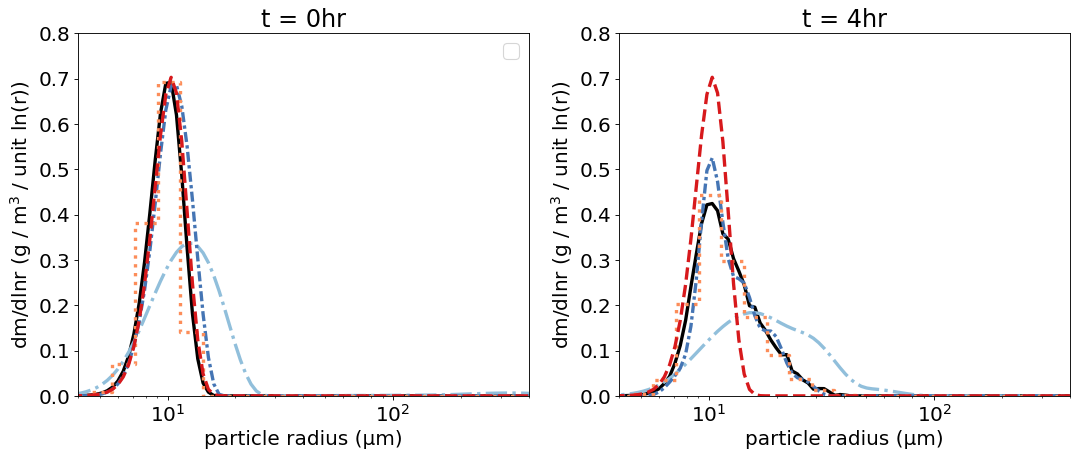

In [15]:
# plot all of them
pyplot.rcParams.update({'font.size':18})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(16,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM sdm_y1: m^3 / m^3 / (unit ln R) --> 1e6 g / m^3 / unit ln R
r_sdm = settings.radius_bins_edges[1:] / si.um
dlnr_sdm = np.log(r_sdm[2]) - np.log(r_sdm[1])

ax[0].plot(r_sdm, sdm_y1[:,0] * 1e6, linestyle=ls[0], color=colors[0], linewidth=3)
ax[1].plot(r_sdm, sdm_y1[:,-1] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)


# COLLOCATION: (um^6 / cm^3) -> 
x = settings.volume_bins_edges[:-1]/si.um**3
yrbf8i = rbf8_i(x)
yrbf8f = rbf8_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf8i * si.cm**3, linestyle=ls[1],color=colors[1],linewidth=3)#, label='Collocation n_bf = 8, init')
ax[1].plot(r_sdm, 3*x*x*yrbf8f * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)
yrbf16i = rbf16_i(x)
yrbf16f = rbf16_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf16i * si.cm**3, linestyle=ls[2],color=colors[2],linewidth=3)#, label='Collocation n_bf = 16, init')
ax[1].plot(r_sdm, 3*x*x*yrbf16f * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].step(r_grid_plt,
            gr_0 * si.cm**3,
            linestyle=ls[3],color=colors[3],linewidth=3)#, label='Flux method, n_bin = 32, init')
ax[1].step(r_grid_plt,  
            gr_f * si.cm**3,
            linestyle=ls[3],color=colors[3], label='Flux method, n_bin = 32',linewidth=3)


# BULK: (um^3 / cm^3) / (um^3)
ymomi = mom_i(x)
ymomf = mom_f(x)
ax[0].plot(r_sdm, 3*x*x*ymomi * si.cm**3, linestyle=ls[4],color=colors[4],linewidth=3)#, label="MOM (3 moments), init")
ax[1].plot(r_sdm, 3*x*x*ymomf * si.cm**3, linestyle=ls[4],color=colors[4], label="MOM (3 moments)",linewidth=3)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel("particle radius (µm)")
#ax[0].set_ylabel("volume density µm$^3$/cm$^3$ per um$^3$")
ax[0].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[1].set_xlabel("particle radius (µm)")
ax[1].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[0].set_xlim([4.0, 400.0])
ax[1].set_xlim([4.0, 400.0])
ax[0].set_ylim([0.0, 0.8])
ax[1].set_ylim([0.0, 0.8])
ax[0].legend()

ax[0].set_title('t = 0hr')
ax[1].set_title('t = 4hr')

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')

#ax[0].grid()
#ax[1].grid()

pyplot.savefig("m(v)_geometric_IC1.pdf", transparent=True)

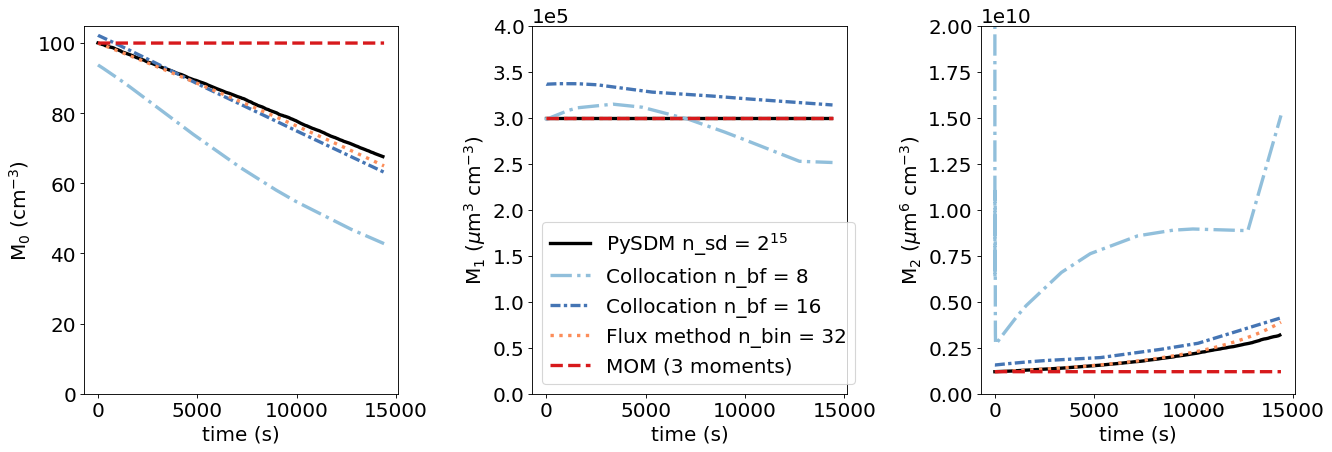

In [16]:
# plot all of them
from matplotlib.ticker import ScalarFormatter
xfmt = ScalarFormatter()
xfmt.set_powerlimits((-3,3))  # Or whatever your limits are . . .

fig, ax = pyplot.subplots(nrows=1, ncols=3, figsize=(17,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM:
ax[0].plot(times_sdm, mom0*si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
ax[1].plot(times_sdm, mom1 / si.um**3 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[2].plot(times_sdm, mom2 / si.um**6 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)

# COLLOCATION:
ax[0].plot(col_8_times, col_8_M_0, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[1].plot(col_8_times, col_8_M_1, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[2].plot(col_8_times, col_8_M_2, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)

ax[0].plot(col_16_times, col_16_M_0, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[1].plot(col_16_times, col_16_M_1, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[2].plot(col_16_times, col_16_M_2, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].plot(t_bott, M0_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[1].plot(t_bott, M1_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[2].plot(t_bott, M2_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)

# # BULK: (um^3 / cm^3) / (um^3)
ax[0].plot(t_cloudy, M0_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)
ax[1].plot(t_cloudy, M1_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)
ax[2].plot(t_cloudy, M2_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)

ax[0].set_xlabel('time (s)')
ax[1].set_xlabel('time (s)')
ax[2].set_xlabel('time (s)')
ax[0].set_ylabel('M$_0$ (cm$^{-3}$)')
ax[1].set_ylabel('M$_1$ ($\mu$m$^3$ cm$^{-3}$)')
ax[2].set_ylabel('M$_2$ ($\mu$m$^6$ cm$^{-3}$)')
ax[0].set_ylim([0, 105])
ax[1].set_ylim([0, 4e5])
ax[2].set_ylim([0, 2e10])
ax[1].legend()
ax[1].yaxis.set_major_formatter(xfmt)

pyplot.tight_layout()
pyplot.savefig("moments_geometric_IC1.pdf", transparent=True)


In [17]:
volume_cutoff = 4/3*np.pi*r_cutoff**3

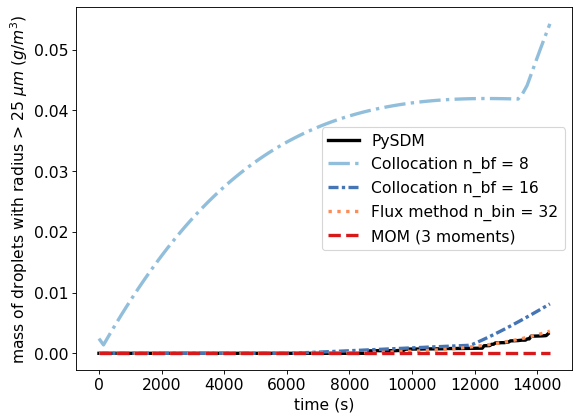

In [18]:
# plot all of them
pyplot.rcParams.update({'font.size':14})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

pyplot.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(times_sdm, sdm_precip[:] / 1e6, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
pyplot.plot(t_precip_8, np.divide(m_precip_8, 1e6), color=colors[1], linestyle=ls[1],label='Collocation n_bf = 8',linewidth=3)
pyplot.plot(t_precip_16, np.divide(m_precip_16, 1e6), color=colors[2], linestyle=ls[2],label='Collocation n_bf = 16',linewidth=3)
pyplot.plot(t_bott, np.divide(mprecip_bin, 1e6), color=colors[3], linestyle=ls[3],label='Flux method n_bin = 32',linewidth=3)
pyplot.plot(t_precip_mom, np.divide(m_precip_mom, 1e6), color=colors[4], linestyle=ls[4],label='MOM (3 moments)',linewidth=3)
pyplot.xlabel('time (s)')
pyplot.ylabel('mass of droplets with radius > 25 $\mu m$ $(g / m^3)$')
pyplot.legend()
pyplot.gca().yaxis.set_major_formatter(xfmt)
pyplot.savefig('m_precip_geometric_IC1.pdf', transparent=True)

## Error Computation

In [20]:
import pickle

def compute_L2_error(y1, y2):
    return np.linalg.norm(y1-y2)/np.linalg.norm(y2)

def bott_m_f(x):
    mf = np.zeros(len(x))
    dlnr_bin = np.mean(np.log(r_grid[2:]) - np.log(r_grid[1:-1]))
    for i in range(len(x)):
        i0 = find_nearest(v_grid,x[i])[0]
        mf[i] = gr_f[i0]#/dlnr_bin*dlnr
    return mf
v_sdm = x

yrbf8f = rbf8_f(v_sdm)
e8f = compute_L2_error(3*yrbf8f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

yrbf16f = rbf16_f(v_sdm)
e16f = compute_L2_error(3*yrbf16f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ymomf = mom_f(v_sdm)
emomf = compute_L2_error(3*ymomf*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ybinf = bott_m_f(v_sdm)
ebinf = compute_L2_error(ybinf*1e-6, sdm_y1[:,-1]*1e6)

print(e8f,e16f,emomf,ebinf)
errs = [e8f, e16f, emomf, ebinf]
pickle.dump(errs, open("geometric_IC1_errors.pkl", "wb" ))

0.6406826395531934 0.17560314049412054 0.609241850964316 0.24553092647826175
